# Package Imports

In [1]:
import pandas as pd
from pathlib import Path
import time
import tqdm
from datetime import datetime
import os
from sklearn.model_selection import KFold
import sys
import pytorch_lightning as plit
import pandas as pd
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix, roc_curve
from sklearn.metrics import auc as skauc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer as MICE
from sklearn.compose import ColumnTransformer
import numpy as np
from multiprocessing import Pool
import multiprocessing
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
import torch
import argparse
import dateutil

# Torch device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# K-fold validation
n_splits = 5  
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Feature Analysis + Filtration

In [2]:
def analyze_features(features_scaled, feature_names, y, k=5, top_n_features=10, return_top_features=False):
    """
    Analyze features using K-means, Linear Regression, and PCA.
    Optionally retain and return only the top N features based on Linear Regression importance.
    
    :param features_scaled: Scaled feature numpy array
    :param feature_names: List of feature names
    :param y: True labels
    :param k: Number of clusters for K-means
    :param top_n_features: Number of top features to retain based on Linear Regression
    :param return_top_features: Whether to return only the top N features
    """
    
    # Linear Regression for feature importance
    lr = LinearRegression()
    lr.fit(features_scaled, y)
    feature_importance_lr = pd.Series(np.abs(lr.coef_), index=feature_names).sort_values(ascending=False)
    print("Feature importance based on Linear Regression:")
    print(feature_importance_lr.head(top_n_features))
    print("\n" + "-"*50 + "\n")
    
    # If top_n_features is specified, retain only the top N features
    features_filtered = features_scaled
    if top_n_features is not None and return_top_features:
        top_features = feature_importance_lr.head(top_n_features).index
        feature_names = list(feature_names)
        features_filtered = pd.DataFrame(features_scaled[:, [feature_names.index(feature) for feature in top_features]])
        features_filtered.columns = top_features
        
        # Update feature_names to reflect the filtered set
        feature_names_filtered = top_features.tolist()
    else:
        feature_names_filtered = feature_names
    
    # Perform PCA on potentially reduced feature set
    pca = PCA()
    pca.fit(features_filtered)
    
    # Analyze explained variance ratio to decide on the number of components
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(cumulative_variance >= 0.95) + 1  # for 95% cumulative variance
    print(f"Proportion of components to retain for 95% cumulative variance: {num_components/len(feature_names_filtered)}")
    
    # Inspect the PCA loadings for the top components
    pca_loadings = pd.DataFrame(pca.components_[:num_components], columns=feature_names_filtered)
    abs_loadings = np.abs(pca_loadings)  # Absolute loadings of features
    feature_importance_pca = abs_loadings.sum(axis=0).sort_values(ascending=False)
    print("Features ranked by their importance based on PCA loadings across retained components:")
    print(feature_importance_pca.head(top_n_features))
    
    # Return the filtered features if requested
    if return_top_features:
        return features_filtered
    else:
        return None

def process_data_chunk_wrapper(chunk, id_conversion):
    """
    Calls process_data_chunk with the given chunk and id_conversion.
    """
    return process_data_chunk(chunk, id_conversion)
    
# Filters features based on their presence in the final patient dataset
def filter_features_on_presence(feature_df, feature_threshold =0.5, patient_threshold = 0.5):
    presence = feature_df.notna().mean()
    filtered_columns = presence[presence > feature_threshold].index
    feature_df = feature_df[filtered_columns]
    
    # Calculate the minimum number of non-NaN/None values required per row based on the proportion
    min_non_nan_count = int(np.ceil(patient_threshold * feature_df.shape[1]))
    
    # Filter rows based on the calculated minimum count of non-NaN/None values
    filtered_df = feature_df.dropna(axis=0, thresh=min_non_nan_count)
    
    return filtered_df
    
def filter_chart_data_optimized(chart_data, admissions_data, max_hours=48, chunks=4):
    # Ensure datetime format
    chart_data['CHARTTIME'] = pd.to_datetime(chart_data['CHARTTIME'], errors='coerce')
    admissions_data['ADMITTIME'] = pd.to_datetime(admissions_data['ADMITTIME'], errors='coerce')

    # Determine chunk size
    chunk_size = len(chart_data) // chunks
    filtered_data_list = []

    for i in range(chunks):
        # Calculate start and end index for each chunk
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size if i < chunks - 1 else len(chart_data)
        chart_data_chunk = chart_data.iloc[start_idx:end_idx]

        # Merge with admissions_data
        merged_data = chart_data_chunk.merge(admissions_data[['SUBJECT_ID', 'ADMITTIME']],
                                             on='SUBJECT_ID', how='inner')
        # Calculate time difference in hours
        merged_data['time_diff'] = (merged_data['CHARTTIME'] - merged_data['ADMITTIME']).dt.total_seconds() / 3600

        # Filter based on time_diff
        filtered_chunk = merged_data.query('0 <= time_diff <= @max_hours').drop(columns=['ADMITTIME', 'time_diff'])
        filtered_data_list.append(filtered_chunk)

    # Concatenate all filtered chunks
    filtered_data = pd.concat(filtered_data_list, ignore_index=True)
    return filtered_data
    
def extract_features_from_chart_data(chart_data, id_conversion, num_processes=16, min_non_nan_proportion=0.01):
    """
    Extract features from chart data using multiprocessing.
    """
    # Split data into chunks
    chunks = np.array_split(chart_data, num_processes)
    
    # Prepare arguments for each chunk processing
    args = [(chunk, id_conversion) for chunk in chunks]
    
    # Process each chunk in parallel
    with Pool(num_processes) as pool:
        results = pool.starmap(process_data_chunk_wrapper, args)
    
    # Combine results from all chunks
    combined = pd.concat(results, axis=0).reset_index(drop=True).groupby('SUBJECT_ID').first()
    
    # Determine the threshold number of non-NaN/non-None values required per column
    threshold_count = int(min_non_nan_proportion * len(combined))
    
    # Drop columns where the number of non-NaN/non-None values is less than the threshold
    filtered_combined = combined.dropna(axis=1, thresh=threshold_count, inplace=False)
    
    return filtered_combined 
    
def process_data_chunk(chunk, id_conversion, value_pick='first'):
    """
    Extract features from a chunk of data, preserving SUBJECT_ID.
    Args:
        - chunk (DataFrame): A chunk of the filtered chart data, preserving SUBJECT_ID.
        - id_conversion (dict): A dictionary for converting item IDs to feature names.
        - value_pick (str): Determines whether to pick the 'first' or 'last' non-empty value for each feature.
    Returns:
        - DataFrame with extracted features for the chunk, including SUBJECT_ID.
    """

    # Ensure SUBJECT_ID is considered during processing
    chunk['FEATURE_NAME'] = chunk['ITEMID'].map(id_conversion).fillna('Unknown')

    # Define aggregation function based on value_pick parameter
    if value_pick == 'first':
        value_func = lambda x: x.dropna().iloc[0] if not x.dropna().empty else None
    elif value_pick == 'last':
        value_func = lambda x: x.dropna().iloc[-1] if not x.dropna().empty else None
    else:
        raise ValueError("value_pick must be 'first' or 'last'")

    agg_funcs = {'VALUE': value_func}
    features = chunk.groupby(['SUBJECT_ID', 'FEATURE_NAME']).agg(agg_funcs).unstack()

    # Flatten Multi-Index columns
    features.columns = [f'{i}_{j}' for i, j in features.columns]
    return features.reset_index()
    
def filter_patients_within_timeframe(data, max_hours):

    max_seconds = max_hours * 3600
    # Mark patients to keep based on the condition
    keep_patients = []
    for i, row in data.iterrows():
        if pd.notnull(row['DEATHTIME']):
            time_diff = (row['DEATHTIME'] - row['ADMITTIME']).total_seconds()
        else:
            time_diff = (row['DISCHTIME'] - row['ADMITTIME']).total_seconds()
        
        if time_diff > max_seconds:
            keep_patients.append(row['SUBJECT_ID'])
    
    return keep_patients
    
def process_data_with_timeframe_filtering(admit_times, discharge_times, death_times, filter_within_timeframe, max_hours, subject_ids):
    death_labels = []
    hospital_stay = []
    filtered_ids = []
    
    for admit, dis, death, subject_id in tqdm.tqdm(zip(admit_times, discharge_times, death_times, subject_ids), total=len(admit_times), desc='Processing mortality'):
        within_timeframe = False
        death_time = (death - admit).total_seconds() if pd.notnull(death) else None
        discharge_time = (dis - admit).total_seconds() if pd.notnull(dis) else None
        
        if death_time and death_time <= max_hours * 3600:
            within_timeframe = True
        elif discharge_time and discharge_time <= max_hours * 3600:
            within_timeframe = True
        
        if filter_within_timeframe and within_timeframe:
            continue  # Skip this patient
        
        # Add the patient's data
        hospital_stay.append(death_time if death_time else discharge_time)
        death_labels.append(1 if death_time else 0)
        filtered_ids.append(subject_id)
    
    return death_labels, hospital_stay, filtered_ids


# Model Operation

In [19]:
# Function for equalizing data
def equalize_data(features, labels):

    data = pd.concat((features, pd.DataFrame({"Death":labels})), axis = 1)
    data = data.sample(frac = 1) 
    true_data = data[data["Death"] == 1]
    false_data = data[data["Death"] == 0]
    true_length, false_length = len(true_data), len(false_data)
    
    # Equalizes labels
    if true_length > false_length:
        sample_fraction = false_length / true_length
        true_data = true_data.sample(frac = sample_fraction)
    else:
        sample_fraction = true_length / false_length
        false_data = false_data.sample(frac = sample_fraction)
        
    # Recombines data
    data = pd.concat((true_data, false_data), axis = 0)
    labels = list(data['Death'])
    features = data.drop(columns = ['Death'])
        
    return features, labels

# Obtains all filtered features and patients
def obtain_features(format_str = "%Y-%m-%d %H:%M:%S",
                max_hours =6, patient_threshold = 0.5, feature_threshold = 0.5,
                top_features = None, filter_within_timeframe = True):

    # Sets global variables to facilitate multiprocessing functions
    global id_conversion, num_hours
 
    # Obtain discharge/death/admission times for label processing
    data = pd.read_csv('dataset/ADMISSIONS.csv')
    chart_data = pd.read_csv('dataset/CHARTEVENTS.csv',)
    patient_data = pd.read_csv('dataset/PATIENTS.csv')[['SUBJECT_ID', 'DOB']]
    patient_data['DOB'] = pd.to_datetime(patient_data['DOB'])

    #micro_data = pd.read_csv('dataset/MICROBIOLOGYEVENTS.csv')
    #note_data = pd.read_csv('./dataset/NOTEEVENTS.csv')
    #prescription_data = pd.read_csv('dataset/PRESCRIPTIONS.csv')

    # Conversion dict for item IDs 
    conversion_data = pd.read_csv('dataset/D_ITEMS.csv')

    # Extract time-related discharge, death, and admit values and converts them to float
    data['ADMITTIME'] = pd.to_datetime(data['ADMITTIME'],)
    data['DISCHTIME'] = pd.to_datetime(data['DISCHTIME'])
    data['DEATHTIME'] = pd.to_datetime(data['DEATHTIME'],)
    
    # New logic to filter patients based on discharge/death time within the timeframe
    admit_times = data['ADMITTIME']
    mapping_discharge = {data['SUBJECT_ID']: data['ADMITTIME'] for _, data in data.iterrows()}
    discharge_times = data['DISCHTIME']
    death_times = data['DEATHTIME']

    admit_times = data['ADMITTIME']
    discharge_times = data['DISCHTIME']
    death_times = data['DEATHTIME']
    
    # Make sure 'ADMITTIME' and 'DOB' are in datetime format
    data['ADMITTIME'] = pd.to_datetime(data['ADMITTIME'])
    patient_data['DOB'] = pd.to_datetime(patient_data['DOB'])

    # Calculate age using relativedelta
    def calculate_age(row):
        return dateutil.relativedelta.relativedelta(row['ADMITTIME'], row['DOB']).years

    # Merge 'data' and 'patient_data' to get 'DOB' and 'ADMITTIME' in the same DataFrame for calculation
    patient_age_df = data.merge(patient_data, on='SUBJECT_ID', how='left')
    patient_age_df['AGE'] = [None for _ in range(len(patient_age_df))]
    patient_age_df.drop_duplicates(inplace = True)
    
    # Apply the age calculation
    patient_age_df['AGE'] = patient_age_df.apply(calculate_age, axis=1)
    patient_age_df = patient_age_df[['SUBJECT_ID', 'AGE']].copy()
    
    # Filter based on discharge/death time within the timeframe and other logic...
    death_labels, hospital_stay, filtered_ids = process_data_with_timeframe_filtering(
        admit_times, discharge_times, death_times, filter_within_timeframe, max_hours, subject_ids = data['SUBJECT_ID'])
    
    # Ensure filtered_ids is a list of IDs that should be kept
    chart_data = chart_data[chart_data['SUBJECT_ID'].isin(filtered_ids)]
    
    mortality_labels = pd.DataFrame({
        'SUBJECT_ID': filtered_ids,
        'Death':death_labels
    })
    
    # Convert ITEMID to biomedical statistic labels
    id_conversion = {row['ITEMID']: row['LABEL'] for _, row in conversion_data.iterrows()}
    
    # Convert CHARTTIME to datetime
    chart_data['CHARTTIME'] = pd.to_datetime(chart_data['CHARTTIME'])

    # Convert times outside the loop
    chart_data['CHARTTIME'] = pd.to_datetime(chart_data['CHARTTIME'])

    # Properly adds admit times to df
    print('Adding times...')
    chart_admit = [mapping_discharge[subject_id] if subject_id in mapping_discharge else None for subject_id in chart_data['SUBJECT_ID']]
    chart_data['admit_time'] = chart_admit
    chart_data['admit_time'] = pd.to_datetime(chart_data['admit_time'], errors = 'coerce')
    chart_data = chart_data.dropna(subset = ['admit_time'])

    # Ensure dateti2me format and handle NaN values
    chart_data['CHARTTIME'] = pd.to_datetime(chart_data['CHARTTIME'], errors='coerce')
    chart_data = chart_data.dropna(subset=['CHARTTIME'])

    # Filter chart_data to include only entries within the specified time frame
    print('Filtering data...')
    chart_data = filter_chart_data_optimized(chart_data, data, max_hours=max_hours)
    
    print('Obtaining features...')
    feature_df = extract_features_from_chart_data(chart_data, id_conversion, num_processes=16)
  
    filtered_feature_df = filter_features_on_presence(feature_df, feature_threshold = feature_threshold, patient_threshold = patient_threshold)

    # Ensure SUBJECT_ID is a column if it's not already
    patient_data_filtered = filtered_feature_df.reset_index(inplace=False)
   
    # Merge with mortality labels
    patient_data = patient_data_filtered.merge(mortality_labels, on='SUBJECT_ID', how='left')

    # Merge with ages
    patient_age_df = patient_age_df.drop_duplicates()
    patient_data = patient_age_df.merge(patient_data, on='SUBJECT_ID',)
    print(len(patient_data))
    
    # Drops columns with all NaN values and duplicate columns
    patient_data = patient_data.dropna(axis=1, how='all')
    patient_data = patient_data.T.drop_duplicates().T
    
    labellers = {}
    string_columns_count = 0  # Counter for columns with string values
    for column in tqdm.tqdm(patient_data.columns, total = len(patient_data.columns), desc = 'Labelling data...'):

        # Check if there are any string values in the column
        if patient_data[column].apply(lambda x: isinstance(x, str)).any():

            try:
                # Increment the counter as this column contains string data
                string_columns_count += 1

                # Fill NaN values with a placeholder
                patient_data[column] = patient_data[column].fillna('missing')

                # Initialize LabelEncoder and transform values
                le = LabelEncoder()
                patient_data[column] = le.fit_transform(patient_data[column])
                labellers[column] = le

                # Identify the encoded value for 'missing' placeholder
                missing_label = le.transform(['missing'])[0]

                # Replace the 'missing' encoded value with NaN in the dataframe
                patient_data[column] = patient_data[column].replace(missing_label, None)
            except:
                patient_data[column] = patient_data[column].apply(lambda x: None if isinstance(x, str) else x)

    # Number of filtered patients
    print(f'{len(patient_data.columns)} features remaining after final filtration')
    print(f'{len(patient_data)} patients remaining after final filtration')
    
    # Removes certain features 
    features_to_remove = ['VALUE_Education Learner', 'VALUE_Education Method', 'VALUE_Education Readiness', 'VALUE_Education Response', 
                            'Value_Marital Status', 'VALUE_Religion', 'VALUE_Orientation', 'VALUE_Family Communication',
                            # Potentially remove
                            'VALUE_Code Status']
    
    for feature in features_to_remove:
        try:
            patient_data = patient_data.drop(columns = [feature])
        except:
            pass

    labels = patient_data['Death']
    features = patient_data.drop(columns = ['Death', 'SUBJECT_ID'])
    scaler = StandardScaler()

    numpy_features = np.array([[item for item in row] for row in features.to_numpy()])
    numpy_features = scaler.fit_transform(numpy_features)
    imputer = MICE()
    
    print('Imputing...')
    impute_start = time.perf_counter()
    imputed_data = imputer.fit_transform(numpy_features)
    impute_end = time.perf_counter()
    print(f'MICE Imputation finished in {round((impute_end - impute_start)/60, 4)} minutes!')
    features = pd.DataFrame(imputed_data, columns=features.columns, index=features.index)

    # Analyzes feature importance via a variety of methods and filters features if enabled
    if top_features:
        features = analyze_features(features_scaled = features.to_numpy(), feature_names = features.columns, y = labels,
                                    return_top_features = True, top_n_features = top_features)
    else:
        analyze_features(features_scaled = features.to_numpy(), feature_names = features.columns, y = labels, return_top_features = False)

    return features, labels
    
# Tests all models on the aggregated features and data
def test_models(features, labels, max_hours = 24, name = 'Random Forest'):
    scaler = StandardScaler()
    def k_fold_validation_for_sklearn(clf, features, labels):
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        plt.figure()
        
        for i, (train_index, test_index) in tqdm.tqdm(enumerate(kf.split(features)), total = n_splits):
            
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            # Scale features
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Fit and predict
            clf.fit(X_train, y_train)
            y_prob = clf.predict_proba(X_test)[:, 1]
            
            # Compute ROC curve and AUC for this fold
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = skauc(fpr, tpr)
            aucs.append(roc_auc)
            
            # Interpolate all ROC curves at this points
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            plt.plot(mean_fpr, interp_tpr, alpha=0.4, label = f'split {i} AUC = {round(roc_auc, 3)}')
        
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        # Calculate the mean AUC and std deviation
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        plt.title(f'{name}, ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})')
        plt.legend(loc="lower right")
        plt.show()

    # Equalizes labels
    features, labels = equalize_data(features, labels) 
    print(f'Number of processed data samples: {len(labels)}')
        
    # Prepare the data
    features_array, labels = features.to_numpy(), np.array(labels)
    
    # Random Forest Classifier
    print("Random Forest")
    rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
    k_fold_validation_for_sklearn(rf_clf, features_array, labels)
    
    # XGBoost Classifier
    print("XGBoost")
    xgb_clf = XGBClassifier(n_estimators=1000, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss')
    k_fold_validation_for_sklearn(xgb_clf, features_array, labels)
    
    # Custom-built network
    class NeuralNet(plit.LightningModule):
        def __init__(self, input_size, hidden_size=32):
            super(NeuralNet, self).__init__()
            
            self.network = nn.Sequential(
                nn.Linear(input_size, hidden_size * 8), nn.ReLU(),
                nn.BatchNorm1d(hidden_size * 8), nn.Dropout(0.3),
                
                nn.Linear(hidden_size * 8, hidden_size * 4), nn.ReLU(),
                nn.BatchNorm1d(hidden_size * 4), nn.Dropout(0.3),
                
                nn.Linear(hidden_size * 4, hidden_size * 2), nn.ReLU(),
                nn.BatchNorm1d(hidden_size * 2), nn.Dropout(0.3),
                
                nn.Linear(hidden_size * 2, hidden_size), nn.ReLU(),
                
                nn.Linear(hidden_size, hidden_size), nn.ReLU(),
                nn.BatchNorm1d(hidden_size), nn.Dropout(0.5),
            )

            self.final_linear = nn.Linear(hidden_size, 1)
            self.sigmoid = nn.Sigmoid()
            self.residual_transform = nn.Linear(input_size, hidden_size)
            
            # L1 and L2 regularization are defined but not used as layers
            
        def forward(self, x):
            residual = self.residual_transform(x)
            out = self.network(x)
            #out += residual  # Add residual connection
            out = self.final_linear(out)
            out = self.sigmoid(out)
            return out.squeeze()

        def training_step(self, batch, batch_idx):
            inputs, labels = batch
            outputs = self(inputs)
            loss = nn.BCELoss()(outputs, labels.view(-1))  # BCELoss for binary classification

            # Apply L1 and L2 regularization
            l1_reg = torch.tensor(0.)
            l2_reg = torch.tensor(0.)
            for param in self.parameters():
                l1_reg = l1_reg + torch.norm(param, 1)
                l2_reg = l2_reg + torch.norm(param, 2)

            # Regularization strengths need to be defined; for example:
            lambda1, lambda2 = 0.005, 0.005
            loss += lambda1 * l1_reg + lambda2 * l2_reg
            self.log("train_loss", loss)
            return loss

        def configure_optimizers(self):
            optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
            return optimizer
    
    def k_fold_validation_for_pytorch(model_class, features, labels, input_size):
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        plt.figure(figsize=(10, 8))
    
        for train_index, test_index in tqdm.tqdm(kf.split(features), total = n_splits,):
            # Prepare data
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            # Convert to tensors
            X_train_tensor, y_train_tensor = torch.FloatTensor(X_train), torch.FloatTensor(y_train)
            X_test_tensor, y_test_tensor = torch.FloatTensor(X_test), torch.FloatTensor(y_test)
            
            # DataLoader setup
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
            
            # Model setup
            model = model_class(input_size=input_size)
            trainer = plit.Trainer(max_epochs=60)
            trainer.fit(model, train_loader)
            
            # Evaluate
            model.eval()
            with torch.no_grad():
                y_prob = model(X_test_tensor).numpy()
            
            # Compute ROC curve and AUC for this fold
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = skauc(fpr, tpr)
            aucs.append(roc_auc)
            
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            plt.plot(mean_fpr, interp_tpr, alpha=0.4)
        
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        plt.title(f'Custom Neural Network Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})')
        plt.legend(loc="lower right")
        plt.show()
    
    print("Custom Neural Network")
    k_fold_validation_for_pytorch(NeuralNet, features_array, labels, input_size=features.shape[1])


# Main Runtime + Config

In [13]:
# Config options for mode
hours = 5
feature_threshold = 0.5
patient_threshold = 0.5
top_features = None

# Obtains features
features, labels = obtain_features(max_hours = hours, feature_threshold = feature_threshold,
                                   patient_threshold = patient_threshold, top_features = top_features)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Number of processed data samples: 9648
Random Forest


100%|██████████| 5/5 [01:25<00:00, 17.17s/it]


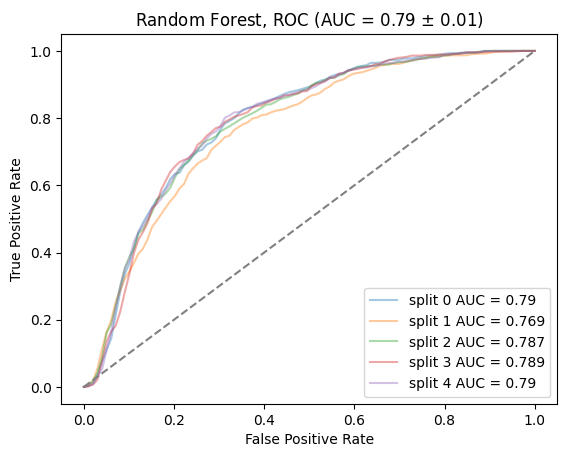

XGBoost


 40%|████      | 2/5 [06:25<09:20, 186.78s/it]

In [ ]:
# Tests model
test_models(features, labels, max_hours = hours)